In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from datetime import datetime, timedelta

In [2]:
# Read the Excel file
df = pd.read_excel('yahoo_data.xlsx', sheet_name='Sheet1')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         1258 non-null   object 
 1   Open         1258 non-null   float64
 2   High         1258 non-null   float64
 3   Low          1258 non-null   float64
 4   Close*       1258 non-null   float64
 5   Adj Close**  1258 non-null   float64
 6   Volume       1258 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 68.9+ KB


In [4]:
df.describe()

,Open,High,Low,Close*,Adj Close**,Volume
count,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1.258000e+03
mean,29595.823045,29776.945739,29402.432226,29599.361677,29599.361677,3.450636e+08
std,4006.078299,4009.007573,4004.949066,4007.468822,4007.468822,1.069142e+08
min,19028.360000,19121.010000,18213.650000,18591.930000,18591.930000,8.615000e+07
25%,26041.267500,26163.155000,25877.872500,26027.120000,26027.120000,2.773125e+08
50%,29201.410000,29335.685000,28996.500000,29199.460000,29199.460000,3.247250e+08
75%,33604.027500,33825.445000,33346.827500,33600.342500,33600.342500,3.875100e+08
max,36722.600000,36952.650000,36636.000000,36799.650000,36799.650000,9.159900e+08


In [5]:
df.isna().sum()

Date           0
Open           0
High           0
Low            0
Close*         0
Adj Close**    0
Volume         0
dtype: int64

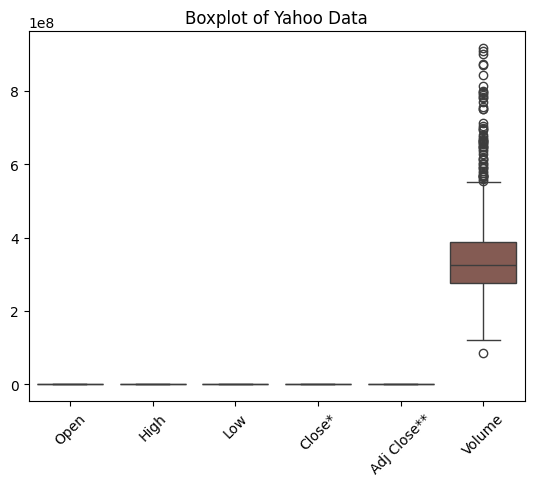

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.boxplot(data=df)
plt.xticks(rotation=45)
plt.title('Boxplot of Yahoo Data')
plt.show()

In [9]:
# Remove outliers from the 'Volume' column using the IQR method
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)  
    Q3 = df[column].quantile(0.75)  
    IQR = Q3 - Q1  

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter the DataFrame to remove outliers
    df_filtered = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df_filtered

# Apply the function to remove outliers from the 'Volume' column
df = remove_outliers_iqr(df, 'Volume')


In [10]:
# Step 2: Calculate Financial Indicators
def calculate_indicators(df):
    df['SMA_20'] = df['Close*'].rolling(window=20).mean()
    df['EMA_20'] = df['Close*'].ewm(span=20, adjust=False).mean()
    df['RSI'] = 100 - (100 / (1 + df['Close*'].pct_change().rolling(window=14).mean() / 
                              df['Close*'].pct_change().rolling(window=14).std()))

    rolling_std = df['Close*'].rolling(window=20).std()
    
    df['Upper_Band'] = df['SMA_20'] + (2 * rolling_std)
    df['Lower_Band'] = df['SMA_20'] - (2 * rolling_std)

    df.dropna(inplace=True)
    return df

In [11]:
# Step 3: Unsupervised Anomaly Detection (Isolation Forest)
def detect_anomalies_isolation_forest(df):
    model = IsolationForest(contamination=0.02, random_state=42)
    df['Anomaly'] = model.fit_predict(df[['Close*', 'SMA_20', 'EMA_20', 'RSI']])
    df['Anomaly'] = df['Anomaly'].apply(lambda x: 1 if x == -1 else 0)
    return df

In [12]:
# Step 4: Time-Series Forecasting with LSTM
def build_lstm_model():
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(30, 1)),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

In [13]:
def train_lstm(df):
    scaler = MinMaxScaler()
    df_scaled = scaler.fit_transform(df[['Close*']])
    
    X, y = [], []
    for i in range(30, len(df_scaled)):
        X.append(df_scaled[i-30:i, 0])
        y.append(df_scaled[i, 0])
    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    
    model = build_lstm_model()
    model.fit(X, y, epochs=10, batch_size=16)
    
    return model, scaler

In [14]:
def predict_anomalies(model, scaler, df):
    df_scaled = scaler.transform(df[['Close*']])
    X_test = []
    for i in range(30, len(df_scaled)):
        X_test.append(df_scaled[i-30:i, 0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)
    df['Forecast'] = np.nan
    df.iloc[30:, df.columns.get_loc('Forecast')] = predictions.flatten()
    df['Deviation'] = abs(df['Close*'] - df['Forecast'])
    df['Anomaly_LSTM'] = df['Deviation'] > 2 * df['Deviation'].std()
    return df

In [15]:
# Step 5: Visualization
def plot_anomalies(df):
    plt.figure(figsize=(14, 7))
    sns.lineplot(x=df.index, y=df['Close*'], label='Close Price')
    sns.scatterplot(x=df[df['Anomaly'] == 1].index, y=df[df['Anomaly'] == 1]['Close*'],
                    color='red', label='Isolation Forest Anomalies', s=100)
    sns.scatterplot(x=df[df['Anomaly_LSTM']].index, y=df[df['Anomaly_LSTM']]['Close*'],
                    color='blue', label='LSTM Anomalies', s=100)
    plt.title('Stock Price Anomalies')
    plt.legend()
    plt.show()

C:\Users\mohammed hassan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - loss: 0.0592
Epoch 2/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0063
Epoch 3/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0066
Epoch 4/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0045
Epoch 5/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0049
Epoch 6/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0052
Epoch 7/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0043
Epoch 8/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0045
Epoch 9/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0044
Epoch 10/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0038
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step


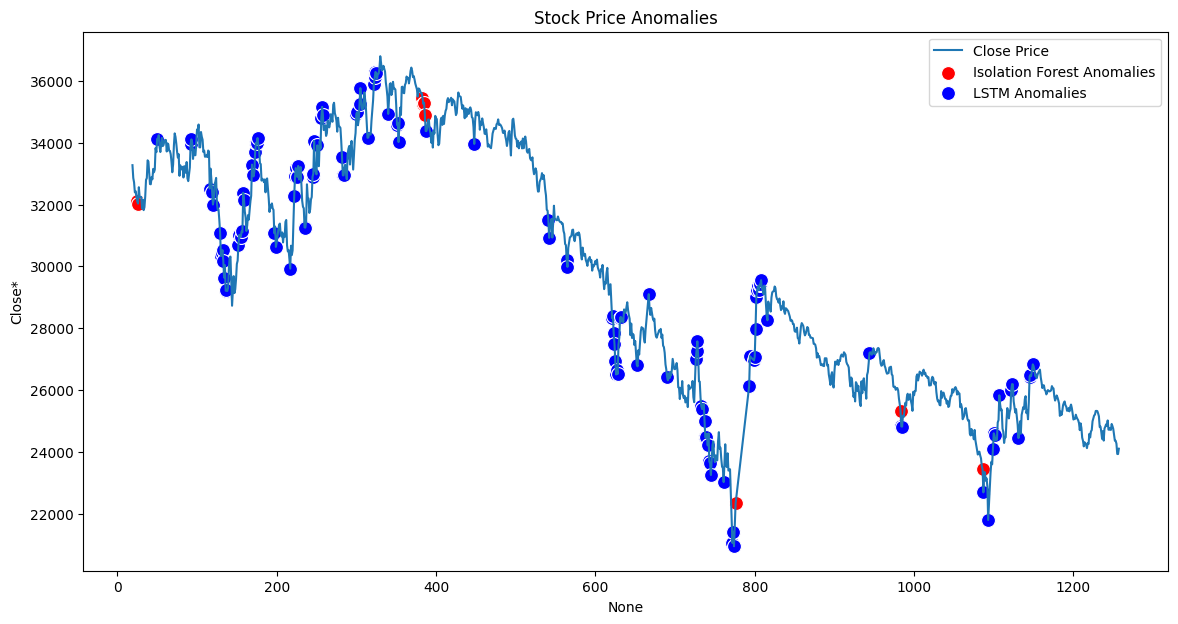

In [16]:
# Running the pipeline
df = calculate_indicators(df)
df = detect_anomalies_isolation_forest(df)
lstm_model, scaler = train_lstm(df)
df = predict_anomalies(lstm_model, scaler, df) 
plot_anomalies(df)